In [1]:
import sys
import pickle
sys.path.insert(1, '../../../eispy2d/library/')
import experiment as exp
import inputdata as ipt
import results as rst
import numpy as np
import pingouin as pg
from matplotlib import pyplot as plt
from statsmodels import stats

# Does something change when we let the algorithm run more iterations?

The authors reported results in their paper for 20,000 iterations and assuming the knowledge of the bounds of the relative permittivity. Previous experiments did not considered these two aspects. Will we have different results if we apply these items?

## Design of the Experiment

For this experiment, we will consider a 7x7 image resolution in all scaling steps. Since 20,000 iterations per scaling step means a lot of time, we will run only two scaling steps. Futher experiments may consider more scaling steps. The scattering inverse problem is the same than the previous experiments: the scattering of a circular cylinder at the center of the image with 11 incidences, 10 measurements and no noise.

The PSO algorithm will be run with the following configuration:

* Number of particles: 250;
* Fixed number of iterations for each scaling iteration: 20,000;
* Resolution of each scaling iteration: 7x7.

In [5]:
# File name and location
experiment_name = 'exp02'
instance_name = 'dielectric_cylinder'
file_path = './data/'
names = ['1 it.', '2 it.']

# Load instance data
instance = ipt.InputData(import_filename=instance_name,
                         import_filepath=file_path)

# Load the results of each execution of each resolution
executions = []
for i in range(len(names)):
    with open(file_path + experiment_name + '_' + names[i], 'rb') as datafile:
        executions.append(pickle.load(datafile))

# Load the results of the three resolutions
results = []
for i in range(len(names)):
    results.append(rst.Results(import_filename=experiment_name + '_' + instance_name + '_' + names[i],
                               import_filepath=file_path))

## Recovered Maps

The original profile and the best recovered ones (according to the objetive function evaluation) by each algorithm are displayed in the Figure below:

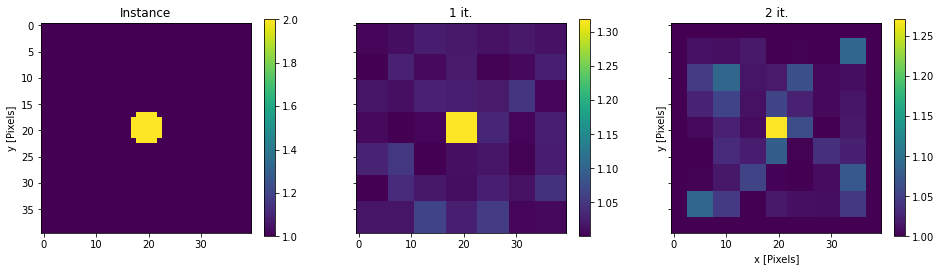

In [10]:
# Create figures and axis
fig, axis = plt.subplots(nrows=1,
                         ncols=3,
                         sharey=True,
                         sharex=True,
                         figsize=(16, 4))

# Original profile
img = axis[0].imshow(instance.epsilon_r)
plt.colorbar(img, ax=axis[0])
axis[0].set_ylabel('y [Pixels]')
axis[0].set_title('Instance')

# 1 iteration
img = axis[1].imshow(results[0].epsilon_r)
plt.colorbar(img, ax=axis[1])
axis[1].set_title(names[0])

# 2 iterations
img = axis[2].imshow(results[1].epsilon_r)
axis[2].set_ylabel('y [Pixels]')
axis[2].set_title(names[1])
plt.colorbar(img, ax=axis[2])
axis[2].set_xlabel('x [Pixels]')

plt.show()

Both algorithms were able to identify a region with more contrast at the center of the image. However, the contrast value is signicantly lower than the original profile. If more scaling steps were run, we might have had a closer estimation of the contrast value of the scatter, since the reduction of the image would lead to higher contrast values.

## Convergence comparison

The convergence curve of each version of the algorithm is another important information to be analyzed. Since each run might have a different number of PSO iterations and there are multiple runs per resolution setting, this information will be analyzed using the percentage averages, i.e., the average among runs with 0, 10, 20, ..., 100% of all PSO iterations (including first and second scaling iterations). In addition to the objective function, we will also compare the convergence of $\zeta_{\epsilon PAD}$ error.

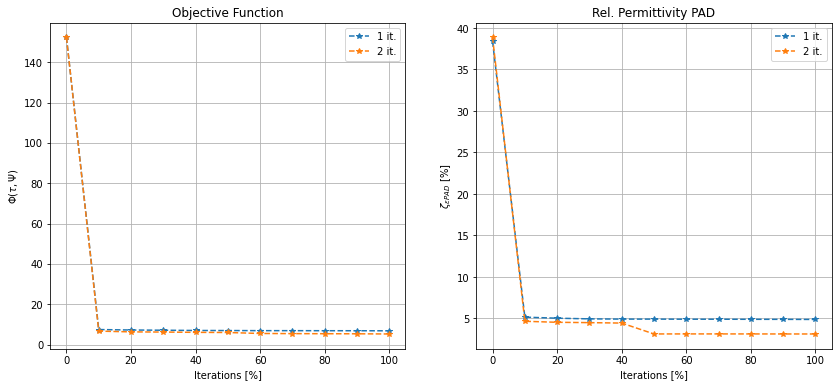

In [11]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
percent = np.arange(0, 110, 10)

# Convergence - Objective Function
for i in range(len(results)):
    axis[0].plot(percent, results[i].objective_function, '--*', label=names[i])
axis[0].legend()
axis[0].grid()
axis[0].set_xlabel('Iterations [%]')
axis[0].set_ylabel(r'$\Phi(\tau, \Psi)$')
axis[0].set_title('Objective Function')

# Convergence - Rel. Permittivity PAD
for i in range(len(results)):
    axis[1].plot(percent, results[i].zeta_epad, '--*', label=names[i])
axis[1].legend()
axis[1].grid()
axis[1].set_xlabel('Iterations [%]')
axis[1].set_ylabel(r'$\zeta_{\epsilon PAD}$ [%]')
axis[1].set_title('Rel. Permittivity PAD')

plt.show()

Even though the second scaling iteration did not result in a significant reduction in the objective function evaluation, the reduction of the mean error per pixel is significant. This is probably due to the area reduction, which contributes a lot to the reduction of this kind of error but did not contribute to a better estimation of the contrast value.

## Comparing quantiles and confidence intervals of means

If we take the assessment of the objective function and the indicators found in the last iteration of the executions, we can make a comparison among the different versions regarding the quality of the final solution found. From these information of the multiple executions, we can compare the quantiles of these samples:

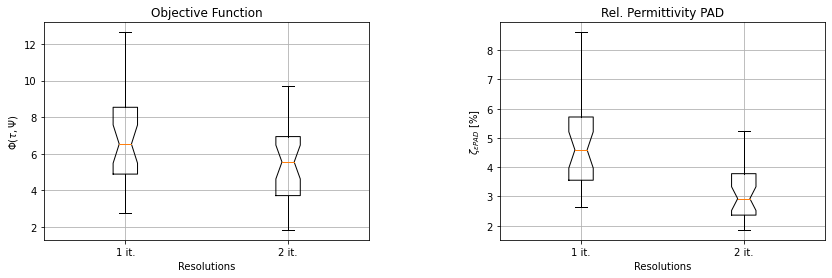

In [12]:
# Allocate arrays
fx = np.zeros((len(names), len(executions[0])))
zeta_epad = np.zeros((len(names), len(executions[0])))

# Collect information
for i in range(len(names)):
    for j in range(len(executions[i])):
        fx[i, j] = executions[i][j].objective_function[-1]
        zeta_epad[i, j] = executions[i][j].zeta_epad[-1]

# Create figure object
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig.subplots_adjust(wspace=.4)

# Objective function
axis[0].boxplot(fx.T, notch=True, labels=names)
axis[0].grid()
axis[0].set_xlabel('Resolutions')
axis[0].set_ylabel(r'$\Phi(\tau, \Psi)$')
axis[0].set_title('Objective Function')

# Rel. Permittivity PAD
axis[1].boxplot(zeta_epad.T, notch=True, labels=names)
axis[1].grid()
axis[1].set_xlabel('Resolutions')
axis[1].set_ylabel(r'$\zeta_{\epsilon PAD}$ [%]')
axis[1].set_title('Rel. Permittivity PAD')

plt.show()

The confidence intervals for the median values of the objective function were close for both algorithms. However, as the previous figure may suggest, the confidence interval for $\zeta_{\epsilon PAD}$ is significantly different. This may indicate that the means will also have a different interval:

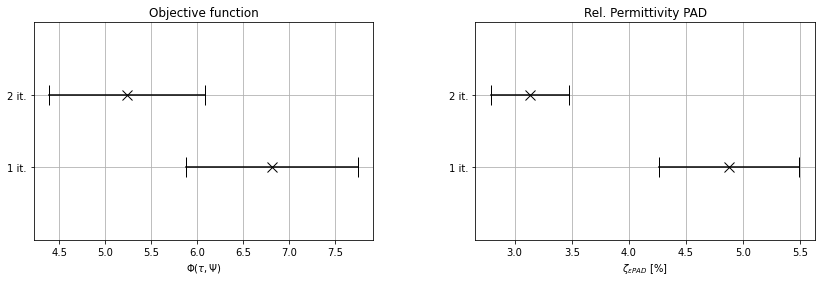

In [13]:
# Create figure object
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig.subplots_adjust(wspace=.3)

for i in range(len(names)):

    # Compute confidence interval for objective function
    info = stats.weightstats.DescrStatsW(fx[i, :])
    cf = info.tconfint_mean()
    axis[0].plot([cf[0], cf[1]], [i, i], '-|k', markersize=20)
    axis[0].plot([np.mean(fx[i, :])], [i], 'xk', markersize=10)

    # Compute confidence interval for zeta_epad
    info = stats.weightstats.DescrStatsW(zeta_epad[i, :])
    cf = info.tconfint_mean()
    axis[1].plot([cf[0], cf[1]], [i, i], '-|k', markersize=20)
    axis[1].plot([np.mean(zeta_epad[i, :])], [i], 'xk', markersize=10)

# Set axis
axis[0].set_yticks(range(len(names)))
axis[0].set_yticklabels(names)
axis[0].set_ylim(ymin=-1, ymax=len(names))
axis[0].grid()
axis[0].set_title('Objective function')
axis[0].set_xlabel(r'$\Phi(\tau, \Psi)$')

# Set axis
axis[1].set_yticks(range(len(names)))
axis[1].set_yticklabels(names)
axis[1].set_ylim(ymin=-1, ymax=len(names))
axis[1].grid()
axis[1].set_xlabel(r'$\zeta_{\epsilon PAD}$ [%]')
axis[1].set_title('Rel. Permittivity PAD')


plt.show()

Before taking conclusions on the confidence interval of means, let's check out the normality assumption:

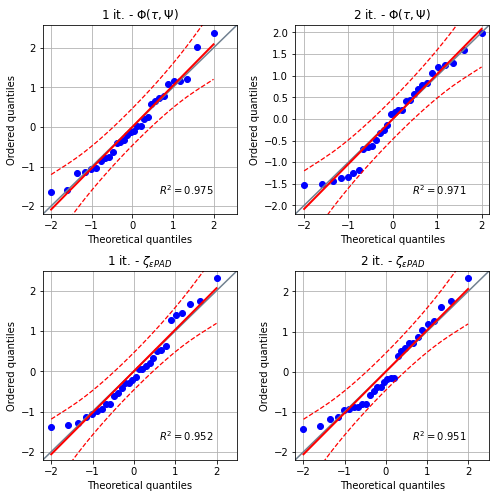

In [14]:
# Create figure object
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig.subplots_adjust(wspace=.3, hspace=.3)

for i in range(len(names)):

    # QQ Plot - Objective function
    pg.qqplot(fx[i, :], ax=axis[0, i])
    axis[0, i].grid()
    axis[0, i].set_title(names[i] + r' - $\Phi(\tau, \Psi)$')

    # QQ Plot - Rel. Permittivity PAD
    pg.qqplot(zeta_epad[i, :], ax=axis[1, i])
    axis[1, i].grid()
    axis[1, i].set_title(names[i] + r' - $\zeta_{\epsilon PAD}$')

plt.show()

Since no significant deviation from the normality assumption is observed, we may affirm that the second scaling iteration did not result in an improvement of the objective function evaluation for this problem, while it definitely result in the reduction of the mean error per pixel.

## Conclusions

The algorithm as a whole seems to be working since for both cases a scatter was identified in the expected position (even though the constrast value was not as close as desirable). However, more scaling steps would possibly contributing to the approximation of the contrast value of the scatter. In fact, the authors ran 6 scaling steps in their original paper. Futher experimentation should consider this.